
# Sector Specific Intraday Pairs Trading


Abstract:

Inspired by guest speakers' discussions of trading strategies based on correlation signals, I wanted to implement a pairs trading strategy that also diversified risk across various sectors and took into account the current macro environment. Using moving averages to represent normalized deviations of the price ratio from the mean, I was able to implement a mildly successful strategy as backtested for 2 years.

Introduction and Review of Existing Literature:

The inspiration came from a guest lecturer's presentations desribing the signals HFT traders usually trade on. Specifically,  how the price movements between very related securities can be correlated, and how this relationship can be traded on.

Initially, the goal was to look at how correlation between two securities changes in response to a third variable that would serve as a leading indicator. I tried looking at securities that were related extra strongly because of recent macro events like the ukraine war, and to try and gain an edge in exploiting enhanced short term correlations between otherwise loosely correlted assets like gold and wheat. I was additionally inspired by Reigneron et. al.'s paper that detailed how "downward index trends increase the average correlation between stocks (as measured by the most negative eigenvalue of the conditional correlation matrix), and makes the market mode more
uniform. Upward trends, on the other hand, also increase the average correlation between stocks but rotates the corresponding market mode away from uniformity." Spikes in volaility that lead to market down- or uptrends, such as those seen after the breakout of the war in Ukraine, dramatically increased correlations between assets.


> Gold and wheat over 5y:

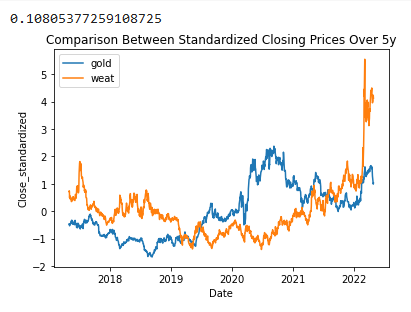

Gold and Wheat in the past 4 months:

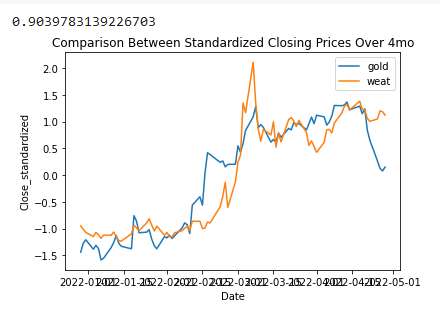

However, this was too noisy to trade on. It was also highly unlikely that such outlier correlations would persist in the long term and that we would be able to find enough such "recently correlated" pairs to trade on. Looking for something a bit more robust, I instead decided to put our own spin on Michael Zhu and Rohan Hajela's pairs trading strategy, diversifying it to take into account macro events like the Ukraine war, various other industry sectors, and to trade on intraday price movements.

Pairs trading is a market-neutral strategy that looks at pairs of securities whose price movements are historically highly correlated. Thus, when the price spread deviates significantly from its historical mean, we can long the temporarily devalued "bottom" security in the spread and short the temporarily overvalued "top" one, betting that they will eventually return to the mean and exit our position then.
Additionally, "the revenue from the short sale can help cover the cost of the long position, making the pairs trade inexpensive to put on." (Investopedia)
Finally, there should be some sort of stop-loss provision in place to exit the trade if the two securities no longer seem to be correlated and the price spread never return to the mean.

This has been a well known and profitable strategy for years, with academic papers explaining and testing its effetiveness going back as far as the 80s and 90s. See gatev et. al.'s 199 paper "Pairs Trading: Performance of a Relative Value Arbitrage Rule."

In order to gain an edge, I decided to focus on a few industry sectors and trade less noisy products such as blue-chip, large cap equities, ETFs, and very liquid commodities. This way, it expands upon Zhu and Hajela's optimization strategy of distributing risk and trading on multiple pairs while handpicking highly correlated pairs that are also relevant to the current macro environment. Tweaking these could ensure the model stays up to date and can continue to perform as the macro environment evolves. I also chose to look at hourly datapoints for price movements instead of Zhu and Hajela's daily datapoints, since I had access to more precise data and felt that this would improve our model's performance and accuracy.

I adapted Zhu and Hajela's z-score moving average trading signal strategy as well, since it would be effective in accounting for the increased variance in price movements that come from looking at hourly changes.

Dataset:

In [ ]:
#!pip install yfinance
#!pip install yahoofinancials
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import yfinance as yf
from yahoofinancials import YahooFinancials
import datetime
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
yf.pdr_override()

Accessing historical trading data from the yfinance API, I first defined a function to look at the correlation over a certain time period between tickers:

In [ ]:
# Valid periods are: “1d”, “5d”, “1mo”, “3mo”, “6mo”, “1y”, “2y”, “5y”, “10y”, “ytd”, “max”

def corr_tickers(a, b, time='5y'):
  ticker1 = yf.Ticker(a).history(period=time)
  ticker2 = yf.Ticker(b).history(period=time)
  closing1 = ticker1['Close']
  closing2 = ticker2['Close']

  ticker1['Close_standardized'] = (closing1 - np.mean(closing1)) / np.std(closing1)
  ticker2['Close_standardized'] = (closing2 - np.mean(closing2)) / np.std(closing2)

  sns.lineplot(x='Date', y='Close_standardized', data=ticker1)
  sns.lineplot(x='Date', y='Close_standardized', data=ticker2)
  plt.legend([a, b])
  plt.title('Comparison Between Standardized Closing Prices Over ' + time)

  return closing1.corr(closing2)


Looking at the historical correlation between two blue-chip tech stocks Apple and Microsoft, the results are unsurprising:

0.9785784482442094

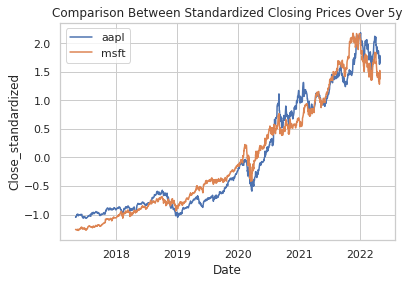

In [ ]:
corr_tickers('aapl', 'msft', '5y')

I then used my expertise in infrastructure investing and  knowledge of the industry's stability and slow pace to track correlations between hypothetically similar ETFs that track the industry. Again, the results were unsurprising at the favorable results.

```
# This is formatted as code
```



0.96121819523751

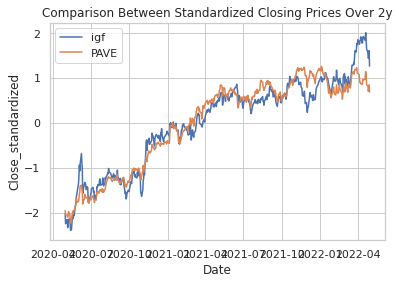

In [ ]:
corr_tickers("igf", "PAVE", "2y")
#infrastructure ETFs

0.9369788394764343

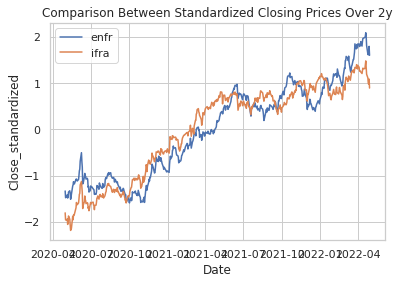

In [ ]:
corr_tickers("enfr", "ifra", "2y")
#infrastructure ETFs

0.9558276679368276

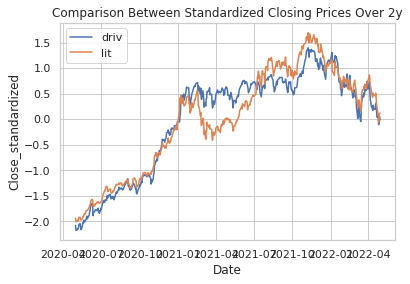

In [ ]:
corr_tickers("driv", "lit", "2y")
#batteries and EVs

Having identified potential pairs, it is important to look more closely at their price spreads' movements over time:

In [ ]:
start = datetime.datetime(2020, 5, 1)
end = datetime.datetime(2022,4,1)

stocks = ['IFRA', 'ENFR', 'aapl', 'msft', 'IGF', 'PAVE', 'GOLD', 'WEAT','DRIV', 'LIT', 'PPA', 'XAR']

precise_df = pd.DataFrame()
for i in stocks:
  if len(precise_df) == 0:
    precise_df = yf.Ticker(i).history(period='2y', interval='60m')['Close'].rename(i).to_frame()
  else:
    precise_df = precise_df.join(yf.Ticker(i).history(period='2y', interval='60m')['Close'].rename(i).to_frame(), how='left')

#print(precise_df.head())
stock1 = 'IFRA'
stock2 = 'ENFR'
#print(len(df))
#df.head()

#stock1_data = yf.Ticker(stock1).history(period='2y', interval='60m')['Close'].rename(stock1)
stock2_data = yf.Ticker(stock2).history(period='2y', interval='60m')['Close'].rename(stock2)

#precise_df = pd.concat([stock1_data, stock2_data], axis=1)
precise_df = precise_df.dropna()

#print(len(precise_df))
#precise_df.head()

In [ ]:
#precise_df['2020-07-09']

First, let's take the pair of insrastructure ETFs IFRA and ENFR as an example to look at. Below we look at the nominal size of the spread, with the black horizontal line representing the mean. This is measured historically over two years. I chose this timeframe since it was long enough to be representative of historical price movements but also ignored the effects of the COVID-19 shock.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


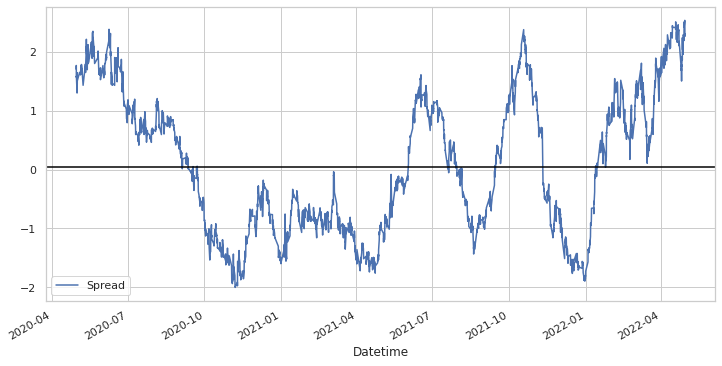

In [ ]:
def spread_difference(s1, s2):
    S1 = precise_df[s1]
    S2 = precise_df[s2]

    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1[s1]
    b = results.params[s1]

    spread = S2 - b * S1
    spread.plot(figsize=(12,6))
    plt.axhline(spread.mean(), color='black')
    plt.legend(['Spread']);

spread_difference(stock1, stock2)

Standardizing the data we have about the price spread's movements, we see that the spread from these two highly correlated securities frequently deviates from the mean only to return a bit later. This looks like a tradeable signal!

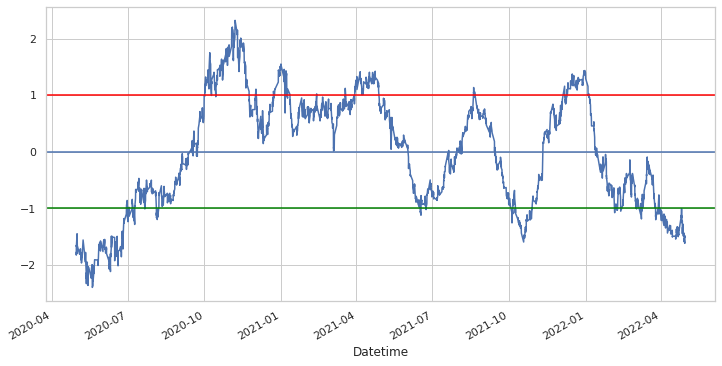

In [ ]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

ratio = precise_df[stock1]/precise_df[stock2]
zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()

Methods:

After running these visual backtests on the rest of our above identified pairs, it was time to move on to a trading model.

In [ ]:
# Modeling section

In [ ]:
index = int(len(ratio) * 0.8)
train = ratio[:index]
test = ratio[index:]

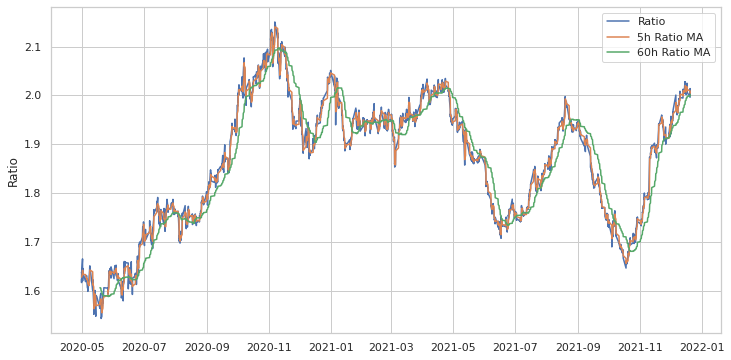

In [ ]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=5, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5h Ratio MA', '60h Ratio MA'])

plt.ylabel('Ratio')
plt.show()

Our moving averges seem to accurately reflect and account for the noise in the data!
Now it is time to define buy/sell signals. These are  overlaid on the graphs of standardized spread deviation below:

(Still for our initial example infrastructure ETFs)

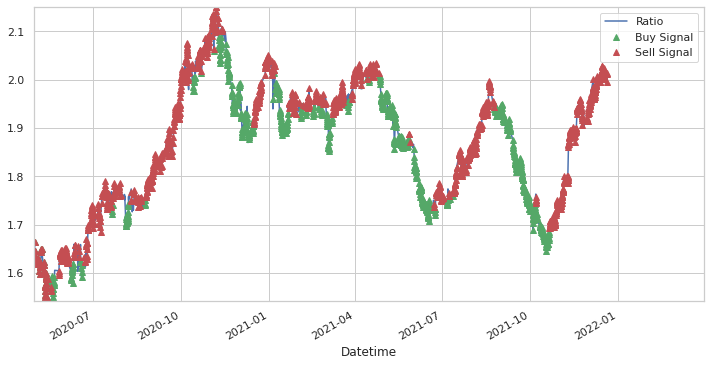

In [ ]:
# Visualizing buy/sell signals in terms of spread ratio

plt.figure(figsize=(12,6))

train[:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[:].plot(color='g', linestyle='None', marker='^')
sell[:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))

plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])

# Changes dates on the axes of the graph
plt.xlim('2020-05-01','2022-04-01')
plt.show()

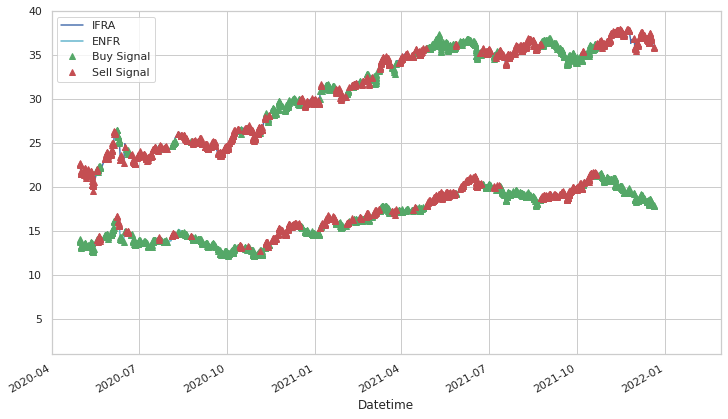

In [ ]:
from re import S
plt.figure(figsize=(12,7))
S1 = precise_df[stock1].iloc[:index]
S2 = precise_df[stock2].iloc[:index]

S1[:].plot(color='b')
S2[:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[:].plot(color='g', linestyle='None', marker='^')
sellR[:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))

#change axis to display on the graph
plt.ylim(1, 40)
plt.xlim('2020-04-01', '2022-03-01')

plt.legend([stock1, stock2, 'Buy Signal', 'Sell Signal'])
plt.show()

Now we define the function that trades on the above signals for a single pair:

In [ ]:
def single_trade(s1, s2, window1, window2, w = 1, use_ratio = False):

    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    S1 = precise_df[s1].iloc[index:]
    S2 = precise_df[s2].iloc[index:]
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std

    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            if use_ratio:
                countS1 -= 1 * ratios[i] * w
                money += (S1[i] - S2[i]) * w * ratios[i]
            else:
                money += (S1[i] - S2[i]  * ratios[i]) * w
                countS1 -= 1 * w

            countS2 += 1 * ratios[i] * w
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            if use_ratio:
                money -= (S1[i] - S2[i]) * w * ratios[i]
                countS1 += 1 * ratios[i] * w
            else:
                money -= (S1[i] - S2[i] * ratios[i]) * w
                countS1 += 1 * w

            countS2 -= 1 * ratios[i] * w

        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))


    return money

Backtesting the strategy for the past two years to the performance of the S&P 500 index, as defined by the index-tracking ETF SPY, actually shows a slight loss. However, this is only trading the infrastructure ETF pair of IFRA and ENFR.

In [ ]:
single_result=single_trade(stock1, stock2, 60, 5, 1)
single_result

-22.43438309101873

In [ ]:
spy_data = yf.Ticker('SPY').history(period='2y', interval='60m')['Close'].rename('SPY').dropna()
#print("Total SPY change over 60h: " + str(spy_data[59] - spy_data[0]))
print("Results of single pair trading over 2y:", single_result)
#print(str(spy_data[0]) + "    " + str(spy_data[int(len(spy_data)*0.8)]))
print("Total SPY change over 2y: ", spy_data[int(len(spy_data)*0.8)]-spy_data[0])

Results of single pair trading over 2y: -22.43438309101873
Total SPY change over 2y:  166.69000244140625


So it is time to implement our model across a wide range of pairs and seek to disperse risk. Let's see how we do compared to SPY!

In [ ]:
#run the model on many diffrent sets of pairs
pairs = [['IFRA', 'ENFR'], ['aapl', 'msft'], ['IGF', 'PAVE'], ['GOLD', 'WEAT'],['DRIV', 'LIT'], ['PPA', 'XAR'] ]
results = 0
for i in pairs:
  results += (single_trade(i[0], i[1], 60, 5, 1))
print(results)

#['DRIV', 'LIT'], ['PPA', 'XAR']

640.6070098197764


In [ ]:
results

640.6070098197764

Results:

In [ ]:
print("Total SPY change over 2y: ", spy_data[int(len(spy_data)*0.8)]-spy_data[0])
print("Results of multiple pairs trading over 2y:", results)

Total SPY change over 2y:  166.69000244140625
Results of multiple pairs trading over 2y: 640.6070098197764


Conclusion:

In conclusion, the model would have performed successfully with the set of six pairs I selected over the past five years. For pairs of highly correlated stocks, it identifies abnormal deviations from the mean in their price ratios and trades the spread.

However, the pairs trading model based on moving averages still needs to be improved in many areas. To start, I need to invest more time to figure out why it performs so differently for highly correlated pairs for which EDA looks similar when looking at historical price spread data and deviaitons from the mean. Additionally, running the model on an expanded set of pairs that were found computationally rather than qualitatively would be beneficial. Again, this goes hand in hand with refining the characteristics of a pair that make it profitable to trade. I also think I could improve our trading signals' precision by tweaking the trade timeline. While I chose hourly-intraday, it would be interesting to compare it to a minute-by-minute frequency or even a daily/quarterly strategy.

References:


https://deepnote.com/@michael-zhu/Pairs-Trading-with-Multiple-ETFs-8ff9cdcf-4c3e-4c1c-9082-eea05dd89da2

https://algotrading101.com/learn/pairs-trading-guide/

https://www.investopedia.com/articles/trading/04/090804.asp

https://github.com/Auquan/Tutorials/blob/master/Pairs%20Trading.ipynb

https://www.nber.org/system/files/working_papers/w7032/w7032.pdf

https://doi.org/10.1016/j.physa.2011.04.007
